In [1]:
import sys,os
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from pprint import pprint
from tqdm import tqdm_notebook as tqdm

In [2]:
stemmer = SnowballStemmer('english')
stopW = stopwords.words('english')
emoji_pattern = re.compile("["
    u"\U0001F600-\U0001F64F"  # emoticons
    u"\U0001F300-\U0001F5FF"  # symbols & pictographs
    u"\U0001F680-\U0001F6FF"  # transport & map symbols
    u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
"]+", flags=re.UNICODE)
stem_map={}

In [3]:
def load_data(filename):
    n = ['id', 'text','HS','TR','AG']
    given_data = pd.read_csv(filename, sep='\t',error_bad_lines=False, names=n, usecols=['text','HS','TR','AG'], skiprows=1)
    raw_data = given_data['text'].values
    labels_TR = list(map(int,given_data['TR'].values))
    labels_AG = list(map(int,given_data['AG'].values))
    labels_HS = list(map(int,given_data['HS'].values))
    
    data = [preprocess(tweet) for tweet in raw_data]
    X = []
    y_AG = []
    y_TR = []
    
    for index,word in enumerate(labels_HS):
        if word:
            X.append(data[index])
            y_AG.append(labels_AG[index]) 
            y_TR.append(labels_TR[index])

    
    return X, y_AG, y_TR

In [4]:
def preprocess(tweet):
    # ' '.join([word for word in tweet.spilt() ])
    tweet = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','URL', tweet)
    tweet = re.sub('@[^\s]+','USER', tweet)
    tweet = tweet.replace("ё", "е")
    tweet = re.sub('[^a-zA-Zа-яА-Я1-9]+', ' ', tweet)
    tweet = re.sub(' +',' ', tweet)
    tweet = emoji_pattern.sub(r'', tweet)

    stemmed_text_token=[]
    tokens = tweet.split(' ')
    for token in tokens:
        if token=='':
            continue
        elif token=='USER' or token=='URL': 
            stemmed_text_token.append(token)
        # if token not in stopW:
        #Need to check performance with and without stopwords.
        else:
            a=stem_map.get(token,0)
            if a==0:
                a=stemmer.stem(token)
                stem_map[token]=a
            stemmed_text_token.append(a)
    return ' '.join(stemmed_text_token)


In [5]:
def classifier(data, labels):
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.01, random_state=324)
    clf = Pipeline([('vect', CountVectorizer(ngram_range=(1, 2))),
                     ('tfidf', TfidfTransformer(use_idf=False,norm='l2')),
                     ('clf', LogisticRegression(solver = 'newton-cg', penalty = 'l2'))])

#     parameters = {
#         'vect__ngram_range': [(1, 1), (1, 2),(2,2)],
#         'tfidf__use_idf': (True, False),
#         'tfidf__norm': ('l1', 'l2'),
# #         'clf__penalty': ['l1', 'l2'],
#         'clf__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
#     }
#     clf = GridSearchCV(clf, parameters, cv=5, iid=False, n_jobs=-1)
#     clf.fit(X_train, y_train)
#     print(clf.best_score_)
#     for param_name in sorted(parameters.keys()):
#         print("%s: %r" % (param_name, clf.best_params_[param_name]))

    clf.fit(X_train,y_train)
    return clf

In [6]:
def test(clf, X, y, print_results=True):
    if print_results:
        print(classification_report(y, clf.predict(X), digits=4))
    return accuracy_score(y, clf.predict(X))

In [7]:
def test_all(clf_aggressive, clf_target, X_test, y_AG_test, y_TR_test, print_results=True):
    print("Results aggressiveness on test data")
    accuracy_ag = test(clf_aggressive, X_test, y_AG_test, print_results=print_results)

    print("Results targeting on test data")
    accuracy_tr = test(clf_target, X_test, y_TR_test, print_results=print_results)
    
    return accuracy_ag, accuracy_tr


In [8]:
print("=====================================================")
training_file = '../Dataset/train_en.tsv'
testing_file = '../Dataset/dev_en.tsv'

X_train, y_AG_train, y_TR_train = load_data(training_file)
X_test, y_AG_test, y_TR_test = load_data(testing_file)

clf_aggressive = classifier(X_train, y_AG_train)
clf_target = classifier(X_train, y_TR_train)

print("Original Data")
print()
accuracy_ag, accuracy_tr = test_all(clf_aggressive, clf_target, X_test, y_AG_test, y_TR_test)
transl_ag = [accuracy_ag]
transl_tr = [accuracy_tr]
eda_ag = [accuracy_ag]
eda_tr = [accuracy_tr]

print("=====================================================")
print("Data Augmentation using EDA technique")
for degree in range(3):
    print("------------------------------------------------")
    print("DATA*{}".format(degree+2))
    filename = '../Dataset/eda_aug/data_degree_{}.tsv'.format(degree+2)
    X_train, y_AG_train, y_TR_train = load_data(filename)
    clf_aggressive = classifier(X_train, y_AG_train)
    clf_target = classifier(X_train, y_TR_train)
    accuracy_ag, accuracy_tr = test_all(clf_aggressive, clf_target, X_test, y_AG_test, y_TR_test)
    eda_ag.append(accuracy_ag)
    eda_tr.append(accuracy_tr)
print("=====================================================")
print("Data Augmentation using Machine Translation")
for degree in range(3):
    print("-------------------------------------------------")
    print("DATA*{}".format(degree+2))
    filename = '../Dataset/transl_aug/data_degree_{}.tsv'.format(degree+2)
    X_train, y_AG_train, y_TR_train = load_data(filename)
    clf_aggressive = classifier(X_train, y_AG_train)
    clf_target = classifier(X_train, y_TR_train)
    accuracy_ag, accuracy_tr = test_all(clf_aggressive, clf_target, X_test, y_AG_test, y_TR_test)
    transl_ag.append(accuracy_ag)
    transl_tr.append(accuracy_tr)



Original Data

Results aggressiveness on test data
              precision    recall  f1-score   support

           0     0.6341    0.6996    0.6652       223
           1     0.6298    0.5588    0.5922       204

    accuracy                         0.6323       427
   macro avg     0.6320    0.6292    0.6287       427
weighted avg     0.6321    0.6323    0.6304       427

Results targeting on test data
              precision    recall  f1-score   support

           0     0.8435    0.9327    0.8858       208
           1     0.9289    0.8356    0.8798       219

    accuracy                         0.8829       427
   macro avg     0.8862    0.8842    0.8828       427
weighted avg     0.8873    0.8829    0.8827       427

Data Augmentation using EDA technique
------------------------------------------------
DATA*2
Results aggressiveness on test data
              precision    recall  f1-score   support

           0     0.6522    0.6726    0.6623       223
           1     0.6294  

In [9]:
def make_plot(results_eda, results_tr, plot_title, yrange):
    x = range(1,5)
    plt.plot(x, results_eda)
    plt.plot(x, results_tr)
    plt.xticks(x, x)
    plt.xlabel("Size of Dataset")
    plt.ylabel("Accuracy")
    plt.ylim(yrange[0], yrange[1])
    plt.title(plot_title)
    plt.legend(['EDA', 'Machine Translation'])
    plt.show()

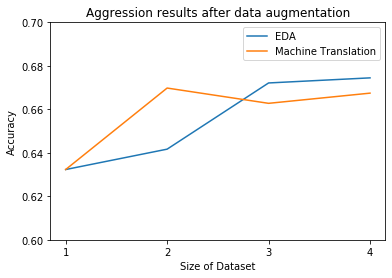

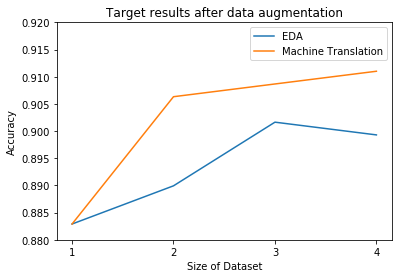

In [10]:
make_plot(eda_ag, transl_ag, "Aggression results after data augmentation", [0.6, 0.7])
make_plot(eda_tr, transl_tr, "Target results after data augmentation", [0.88, 0.92])
